We will use the VGG19 network used by Gatys et al. VGG19 is a simple variant of the VGG16 network introduced in chapter 5, with three more convolutional layers.
This is the general process:
1. Set up a network that computes VGG19 layer activations for the style-reference image, the target image, and the generated image at the same time.
2. Use the layer activations computed over these three images to define the loss function described earlier, which you’ll minimize in order to achieve style transfer.
3. Set up a gradient-descent process to minimize this loss function.

In [1]:
# Let's first define some auxiliary functions
import numpy as np
from keras.applications import vgg19
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

/usr/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


Now we define the paths to the style-reference image and the target image. To make sure that the processed images are a similar size (widely different sizes make style transfer more difficult), we'll resize them all to a shared height of 400 px.

In [2]:
from keras.preprocessing.image import load_img, img_to_array
target_image_path = '/home/ec2-user/stefano_seaside.jpg'
style_reference_image_path = '/home/ec2-user/boccioni.jpg'
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

Let’s set up the VGG19 network. It takes as input a batch of three images: the style reference image, the target image, and a placeholder that will contain the generated image. 

In [3]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
# placeholder image
combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image, style_reference_image, combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)

print('Model loaded.')

80142336/80134624 [==============================] - 1s 0us/step
Model loaded.


Let’s define the content loss, which will make sure the top layer of the VGG19 convnet has a similar view of the target image and the generated image.

In [4]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

Next is the style loss. It uses an auxiliary function to compute the Gram matrix of an input matrix: a map of the correlations found in the original feature matrix.

In [6]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

We define a total variation loss, which operates on the pixels of the generated combination image. It encourages spatial continuity in the generated image, thus avoiding overly pixelated results.

In [7]:
def total_variation_loss(x):
        a = K.square(
            x[:, :img_height - 1, :img_width - 1, :] -
            x[:, 1:, :img_width - 1, :])
        b = K.square(
            x[:, :img_height - 1, :img_width - 1, :] -
            x[:, :img_height - 1, 1:, :])
        return K.sum(K.pow(a + b, 1.25))

The loss that we actually want to minimise is the weighted average of these losses. To compute the content loss, we use only one upper layer — the `block5_conv2` layer — whereas for the style loss, we use a list of layers than spans both low-level and high-level layers. We add the total variation loss at the end.

In [8]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features, combination_features)

In [9]:
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
    
loss += total_variation_weight * total_variation_loss(combination_image)

Finally, you’ll set up the gradient-descent process. In the original Gatys et al. paper, optimization is performed using the L-BFGS algorithm, so that’s what we’ll use here. We set up a Python class named `Evaluator` that computes both the loss value and the gradients value at once, returns the loss value when called the first time, and caches the gradients for the next call.

In [10]:
grads = K.gradients(loss, combination_image)[0]

fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    
evaluator = Evaluator()

Finally, we can run the gradient-ascent process using SciPy’s L-BFGS algorithm, saving the current generated image at each iteration of the algorithm (here, a single iteration represents 20 steps of gradient ascent).

In [11]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'my_result'
iterations = 20

x = preprocess_image(target_image_path)

x= x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                     x,
                                     fprime=evaluator.grads,
                                     maxfun=20)
    
print('Current loss value:', min_val)
img = x.copy().reshape((img_height, img_width, 3))
img = deprocess_image(img)
fname = result_prefix + '_at_iteration_%d.png' % i
imsave(fname, img)
print('Image saved as', fname)
end_time = time.time()
print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Start of iteration 1
Start of iteration 2
Start of iteration 3
Start of iteration 4
Start of iteration 5
Start of iteration 6
Start of iteration 7
Start of iteration 8
Start of iteration 9
Start of iteration 10
Start of iteration 11
Start of iteration 12
Start of iteration 13
Start of iteration 14
Start of iteration 15
Start of iteration 16
Start of iteration 17
Start of iteration 18
Start of iteration 19
Current loss value: 188551680.0
Image saved as my_result_at_iteration_19.png
Iteration 19 completed in 9s


/usr/lib/python3.4/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


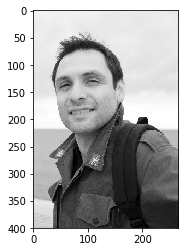

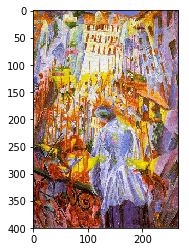

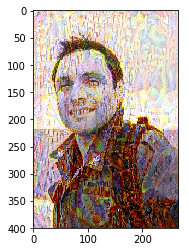

In [12]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()